# ULMFiT + Siamese Network for Sentence Vectors
## Part Three: Classifying

This notebook will use the German Language Model, created in the previous one, to predict categories based on Office FAQ entries. The model will be used as a sentence encoder for a Siamese Network that builds sentence vectors that are feed into a classifier network.

In [1]:
# Needed to load fastai library
import sys
sys.path.append("/data/home/makayser/notebooks/fastai/") # go to parent dir

In [2]:
import fastai
# from fastai.lm_rnn import *
from fastai.text import *
import html

#temp fix
#from old.fastai import lm_rnn as old_lm_rnn

import json
import html
import re
import pickle
from collections import Counter
import random
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn
from sklearn import model_selection
from functools import partial
from collections import Counter, defaultdict
import random

import numpy as np
import torch
import torch.nn as nn
import torch.utils 
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import dataset, dataloader
import torch.optim as optim
import torch.nn.functional as F

import time
import math
import sys
# import data

In [3]:
data_dir = '/data/home/makayser/qa_local/'
token_files = data_dir + 'token/'

In [27]:
torch.cuda.empty_cache()

## Create a new dataloader to create sentence pairs

In [28]:
class SiameseDataLoader():
    def __init__(self, sentence_pairs, pad_val, batch_size=32):
        self.sentence_pairs = sentence_pairs
        self.batch_size = batch_size
        self.index = 0
        self.pad_val = pad_val
     
    def shuffle(self):
        def srtfn(x):
            return x[:, -1] + random.randint(-5, 5)
        
        order = np.argsort(srtfn(self.sentence_pairs))
        self.sentence_pairs = self.sentence_pairs[order]
        
    def __iter__(self):
        return self
    
    def fill_tensor(self, sentences, max_len):
        data = np.zeros((max_len, len(sentences)), dtype=np.long)
        data.fill(self.pad_val)
        
        for i, s in enumerate(sentences): 
            start_idx = max_len - len(s)
            for j, p in enumerate(s):
                data[:,i][start_idx+j] = p
            
        return torch.LongTensor([data.tolist()]).cuda()
     
    def batch(self):
        return self.index//self.batch_size
    
    def __len__(self):
        return len(self.sentence_pairs)//self.batch_size
    
    def __next__(self):
        #how many examples to ananlyise for this round
        num = min(self.batch_size, len(self.sentence_pairs) - self.index)
        
        if num < 1:
            raise StopIteration  # signals "the end"
            
        #collect the sentences
        max_len_a = 0
        max_len_b = 0
        first = []
        second = []
        labels = torch.LongTensor(num)
        
        for i in range(num):
            a, b, l, _ = self.sentence_pairs[self.index + i]
            
            if len(a) > max_len_a:
                max_len_a = len(a)
            
            if len(b) > max_len_b:
                max_len_b = len(b)
            
            first.append(a)
            second.append(b)
            labels[i] = l 
            
        self.index += num
        
        first = self.fill_tensor(first, max_len_a)
        second = self.fill_tensor(second, max_len_b)
        return (first.cuda(),
                (first != self.pad_val).cuda(),
                second.cuda(),
                (second != self.pad_val).cuda(),
                labels.cuda()
               )

In [29]:
itos = pickle.load(open(f'{token_files}itos.pkl', 'rb'))
stoi = defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
vocab_size = len(itos)
pad_tok = stoi['_pad_']

sentence_pairs_train = np.load(f'{token_files}office_tok_train.npy')
sentence_pairs_dev = np.load(f'{token_files}office_tok_dev.npy')
sentence_pairs_test = np.load(f'{token_files}office_tok_test.npy')

def print_sentence(s):
    sentence = ""
    for tok in s:
        sentence += " "+itos[tok]
    print(sentence)

print_sentence(sentence_pairs_train[0][0])
print_sentence(sentence_pairs_train[0][1])

print_sentence(sentence_pairs_dev[0][0])
print_sentence(sentence_pairs_dev[0][1])

print_sentence(sentence_pairs_test[0][0])
print_sentence(sentence_pairs_test[0][1])

 x_bos ändern der anzeigesprache und zeitzone in office 365 business
 x_bos sie können die anzeigesprache und zeitzone für alle ihre office   365-apps und -dienste gleichzeitig ändern .
 x_bos ändern der anzeigesprache und zeitzone in office 365 business
 x_bos sie können die anzeigesprache und zeitzone für alle ihre office   365-apps und -dienste gleichzeitig ändern .
 x_bos ändern der anzeigesprache und zeitzone in office 365 business
 x_bos sie können die anzeigesprache und zeitzone für alle ihre office   365-apps und -dienste gleichzeitig ändern .


In [30]:
sentence_pairs_test[0][0]

[6, 51, 7, 2618, 9, 1526, 8, 27, 125, 238]

In [31]:
itos[7]

'der'

# Check the dataloader

In [32]:
training_data = SiameseDataLoader(sentence_pairs_train, pad_tok)
for batch in training_data:
    sentences = batch[0][0]
    masks = batch[1][0]
    for sentence, mask in zip(sentences.transpose(1,0), masks.transpose(1,0)):
        for tok in torch.masked_select(sentence, mask):
            print(itos[int(tok)], end=' ')
        print("")
    break

x_bos ändern der anzeigesprache und zeitzone in office 365 business 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der anzeige von einem 3d-diagramm 
x_bos ändern der arbeitszeiten und arbeitstage in outlook 
x_bos än

# Evaluate the masking and pooling code

In [33]:
# sentences are in the form [sentence_length, batch_size, embedding_size]
# masks are in the form [sentence_length, batch_size])
sentence_length = 5
batch_size = 3
embedding_size = 4

out = torch.zeros((batch_size, embedding_size))
sentences = torch.tensor([ 
                    [[1,1,1,1], [4,4,4,4], [7,7,7,7]],
                    [[2,2,2,2], [5,5,5,5], [8,8,8,8]],
                    [[0,0,0,0], [6,6,6,6], [9,9,9,9]],
                    [[0,0,0,0], [0,0,0,0], [10,10,10,10]],
                    [[0,0,0,0], [0,0,0,0], [0,0,0,0]]
                    ]).float()

#sentences.shape == [5, 3, 4]

masks = torch.tensor([[[1,1,1], [1,1,1], [0,1,1], [0,0,1], [0,0,0]]]).byte()
#masks.shape == [1, 5, 3]

for i, sentence, mask in zip(range(batch_size), sentences.permute((1,0,2)), masks.squeeze().permute(1,0)):
    mask = mask.unsqueeze(1)
    selected = torch.masked_select(sentence, mask)
    selected = torch.reshape(selected, (-1, embedding_size))
    print(selected)
    max = torch.max(selected, 0)[0]
    print(max)
    out[i] = torch.mean(selected, 0)
print(out)

tensor([[1., 1., 1., 1.],
        [2., 2., 2., 2.]])
tensor([2., 2., 2., 2.])
tensor([[4., 4., 4., 4.],
        [5., 5., 5., 5.],
        [6., 6., 6., 6.]])
tensor([6., 6., 6., 6.])
tensor([[ 7.,  7.,  7.,  7.],
        [ 8.,  8.,  8.,  8.],
        [ 9.,  9.,  9.,  9.],
        [10., 10., 10., 10.]])
tensor([10., 10., 10., 10.])
tensor([[1.5000, 1.5000, 1.5000, 1.5000],
        [5.0000, 5.0000, 5.0000, 5.0000],
        [8.5000, 8.5000, 8.5000, 8.5000]])


## Siamese network

In [34]:
class SiameseClassifier(nn.Module):
    
    def __init__(self, encoder, linear):
        super().__init__()
        self.encoder = encoder
        self.linear = linear
    
    def pool(self, x, masks, is_max):
        #x.shape = sentence length, batch size, embedding size
        #mask.shape = [1, sentence length, batch size]
        
        embedding_size = x.shape[2]
        batch_size = x.shape[1]
        out = torch.zeros((batch_size, embedding_size)).cuda()
        masks = masks.squeeze()
        #print(f'shapes: x {x.shape}, masks {masks.shape}, out {out.shape}')
        
        #shapes: x torch.Size([7, 32, 400]), mask torch.Size([7, 32]), out torch.Size([32, 400])
                
        for i, hidden, mask in zip(range(batch_size), x.permute((1,0,2)), masks.permute(1,0)):
            mask = mask.unsqueeze(1)
            selected = torch.masked_select(hidden, mask)
            selected = torch.reshape(selected, (-1, embedding_size))
            if is_max:
                max_pool = torch.max(selected, 0)[0]
                out[i] = max_pool
            else:
                mean_pool = torch.mean(selected, 0)
                out[i] = mean_pool

        return out

    def pool_outputs(self, output, mask):
        avgpool = self.pool(output, mask, False)
        maxpool = self.pool(output, mask, True)
        last = output[-1]
        return torch.cat([last, maxpool, avgpool], 1)
        
    def forward_once(self, input, mask):
        raw_outputs, outputs = self.encoder(input)
        out = self.pool_outputs(outputs[-1], mask)
        return out
    
    def forward(self, in1, in1_mask, in2, in2_mask):
        u = self.forward_once(in1, in1_mask)
        v = self.forward_once(in2, in2_mask)
        features = torch.cat((u, v, torch.abs(u-v), u*v), 1)
        out = self.linear(features)
        return out 
        
    def reset(self):
        for c in self.children():
            if hasattr(c, 'reset'): c.reset()

class LinearClassifier(nn.Module):
    def __init__(self, layers, dropout):
        super().__init__()
        self.layers = nn.ModuleList([LinearBlock(layers[i], layers[i + 1], dropout) for i in range(len(layers) - 1)])
        
    def forward(self, input):
        x = input
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return l_x


In [35]:
#these are the values used for the original LM
em_sz, nh, nl = 300, 1150, 3 #400
bptt = 70
max_seq = bptt * 20
cats = 32

## Load our pretrained model then build the Siamese network from it

## Training loop
This should be converted over to the fast.ai learner but I'm not sure how to do that yet.

In [36]:
log_interval = 1000
criterion = nn.CrossEntropyLoss()
# criterion = nn.CosineEmbeddingLoss()

def evaluate(model, data_loader):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    
    total_loss = 0.
    num_correct = 0
    total = 0 
    
    for x in data_loader:
        a = x[0]
        a_mask = x[1]
        b = x[2]
        b_mask = x[3]
        l = x[4]
        
        if b.size(1) > 1450:
            print('rejected:', b.size())
            continue
        
        model.reset()
        out = model(a.squeeze(), a_mask.squeeze(), b.squeeze(), b_mask.squeeze()) # squeezed the masks
        loss = criterion(out, l.squeeze())
        total += l.size(0)
        total_loss += l.size(0) * loss.item()
        num_correct += np.sum(l.data.cpu().numpy() == np.argmax(out.data.cpu().numpy(), 1))
        
    return (total_loss / total, num_correct / total)

def train(model, data_loader, optimizer):
    # Turn on training mode which enables dropout.
    start_time = time.time()
    model.train() 
    
    total_loss = 0.
    num_correct = 0
    total = 0 
        
    for x in data_loader:
        a = x[0]
        a_mask = x[1]
        b = x[2]
        b_mask = x[3]
        l = x[4]
        
        optimizer.zero_grad()
        
        if b.size(1) > 1450:
            print('rejected:', b.size())
            continue
        
        model.reset()
        #torch.Size([1, 7, 32])
        
        out = model(a.squeeze(), a_mask.squeeze(), b.squeeze(), b_mask.squeeze()) #squeezed the masks
        loss = criterion(out, target=l.squeeze())
        total += l.size(0)
        total_loss += l.size(0) * loss.item()
        num_correct += np.sum(l.data.cpu().numpy() == np.argmax(out.data.cpu().numpy(), 1))
        
        loss.backward()
        optimizer.step()

        batch = data_loader.batch()
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / total
            elapsed = time.time() - start_time
            batches = len(data_loader)
            ms = elapsed * 1000 / log_interval
            print(f'| {batch:5d}/{batches:5d} batches', end=" ")
            print(f'| ms/batch {ms:5.2f} | loss {cur_loss:5.4f} acc {num_correct / total}')
            #print(f'| ms/batch {ms:5.2f} | loss {cur_loss:5.4f}')
            total_loss = 0
            total = 0
            num_correct = 0
            start_time = time.time()

In [37]:
best_loss = 100
def training_loop(model, epochs, optimizer, scheduler = None):
    
    global best_loss
    for epoch in range(epochs):

        print(f'Start epoch {epoch:3d} training with lr ', end="")
        for g in optimizer.param_groups:
            print(g['lr'], end=" ")
        print("")
        
        training_data = SiameseDataLoader(sentence_pairs_train, pad_tok)
        training_data.shuffle()

        epoch_start_time = time.time()
        
        train(model, training_data, optimizer)
        if scheduler != None:
            scheduler.step()

        dev_data = SiameseDataLoader(sentence_pairs_dev, pad_tok)
        val_loss, accuracy = evaluate(model, dev_data)

        delta_t = (time.time() - epoch_start_time)
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {delta_t:5.2f}s | valid loss {val_loss:5.2f} accuracy {accuracy} learning rates')
        for g in optimizer.param_groups:
            print(g['lr'])
        print('-' * 89)

        if val_loss < best_loss:
            best_loss = val_loss
            with open(f'./siamese_model{val_loss:0.2f}{accuracy:0.2f}.pt', 'wb') as f:
                torch.save(siamese_model, f)

In [38]:
from scipy.signal import butter, filtfilt
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def plot_loss(losses):
    plt.semilogx(losses[:,0], losses[:,1])
    plt.semilogx(losses[:,0], butter_lowpass_filtfilt(losses[:,1], 300, 5000))
    plt.show()

def find_lr(model, model_to_optim, data_loader):
    losses = []
    model.train() 
    criterion = nn.CrossEntropyLoss()
    lr = 0.00001
    for x in data_loader: #a, b, l
        a = x[0]#; print(a.size(), a.squeeze().size())
        a_m = x[1]#; print(a_m.size())
        b = x[2]#; print(b.size(), b.squeeze().size())
        b_m = x[3]#; print(b_m.size(), '\n*')
        l = x[4]
        
        if b.size(1) > 1450:
            #NOTE: bug where 
#             torch.Size([1, 11, 32]) torch.Size([11, 32])
#             torch.Size([1, 11, 32])
#             torch.Size([1, 1568, 32]) torch.Size([1568, 32])
#             torch.Size([1, 1568, 32]) 
#             Throws the following error:
#                 The size of tensor a (1358) must match the size of tensor b (1568) at non-singleton dimension 0
            print('rejected:', b.size())
            continue
            
        
        optimizer = optim.SGD(model_to_optim.parameters(), lr=lr)
        #optimizer = optim.Adam(model_to_optim.parameters(), lr=lr)
        optimizer.zero_grad()
        
        model.reset()
#         a, b, l = torch.Tensor(a), torch.Tensor(b), torch.Tensor(l) #already Tensor objects
        out = model(a.squeeze(), a_m.squeeze(), b.squeeze(), b_m.squeeze())
        loss = criterion(out, l.squeeze())
        
        los_val = loss.item()
        losses.append((lr, los_val))
        if los_val > 5:
            break
        
        loss.backward()
        optimizer.step()
        
        lr *= 1.05
    losses = np.array(losses)
    #plot_loss(losses)
    return losses

In [39]:
WIKI_LM = torch.load("oa_language_model_lr001_e20_v2.pt")

dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.4

WIKI_encoder = MultiBatchRNN(bptt, max_seq, vocab_size, em_sz, nh, nl, pad_tok, dropouti=dps[0], wdrop=dps[2], dropoute=dps[3], dropouth=dps[4])

WIKI_LM[0].state_dict()
WIKI_encoder.load_state_dict(WIKI_LM[0].state_dict()) #SNLI_LM[0].state_dict()

#2 pooled vectors, of 3 times the embedding size
siamese_model = SiameseClassifier(WIKI_encoder, LinearClassifier(layers=[em_sz*3*4, nh, 32], dropout=0.4)).cuda()

rejected: torch.Size([1, 2734, 32])
rejected: torch.Size([1, 1988, 32])
rejected: torch.Size([1, 4200, 32])
rejected: torch.Size([1, 4200, 32])
rejected: torch.Size([1, 1568, 32])
rejected: torch.Size([1, 2138, 32])
rejected: torch.Size([1, 2138, 32])


/anaconda/envs/fastai/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


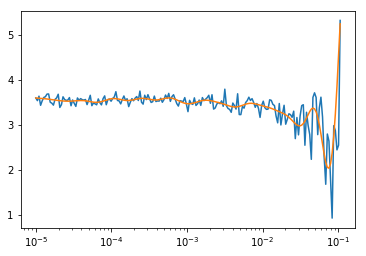

CPU times: user 2min 38s, sys: 51.1 s, total: 3min 29s
Wall time: 3min 30s


In [17]:
%%time

dev_data = SiameseDataLoader(sentence_pairs_dev, pad_tok)
losses = find_lr(siamese_model, siamese_model, dev_data)
plot_loss(np.array(losses))

In [18]:
for b in dev_data:
    print(b[0], '****\n\n')
    print(b[1], '****\n\n')
    print(b[2], '****\n\n')
    print(b[3], '****\n\n')
    print(b[4].size(0), '****\n\n')
    break

tensor([[[   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    6,    6,    6,    6,    6,    6,    6,    6,
             6,    6,    1,    1,    1,    1,    1,    1,    1,    1],
         [   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,   52,   52,   52,   52,   52,   52,   52,   52,
            52,   52,    1,    1,    1,    1,    1,    1,    1,    1],
         [   6,    6,    6,    6,    6,    6,    6,    6,    6,    6,    6,
             6,    6,    6,   11,   11,   11,   11,   11,   11,   11,   11,
            11,   11,    1,    1,    1,    1,    1,    1,    1,    1],
         [  52,   52,   52,   52,   52,   52,   52,   52,   52,   52,   52,
            52,   52,   52,  100,  100,  100,  100,  100,  100,  100,  100,
           100,  100,    6,    6,    6,    6,    6,    6,    1,    1],
         [  11,   11,   11,   11,   11,   11,   11,   11,   11,   11,   11,
            11,   11,   11,   12

In [ ]:
for param in siamese_model.encoder.parameters():
    param.requires_grad = False

optimizer = optim.SGD(siamese_model.linear.parameters(), lr=0.01)
training_loop(siamese_model, 1, optimizer)

Start epoch   0 training with lr 0.01 
|  1000/ 2427 batches | ms/batch 115.12 | loss 1.4568 acc 0.63596875


In [ ]:
torch.save(siamese_model, "siamese_model_e0_lr01_v0.pt")

In [ ]:
# siamese_model = torch.load("./siamese_model0.500.81.pt")

In [ ]:
for param in siamese_model.encoder.parameters():
    param.requires_grad = True

for lr in [x/200+0.005 for x in range(20)]:
    optimizer = optim.SGD(siamese_model.parameters(), lr=lr)
    training_loop(siamese_model, 1, optimizer)

In [ ]:
torch.save(siamese_model, "siamese_model_e1_lr01_v0.pt")

In [ ]:
epochs = 10
optimizer = optim.SGD(siamese_model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0.001)
training_loop(siamese_model, epochs, optimizer, scheduler)

In [ ]:
torch.save(siamese_model, "siamese_model_e10_lr1_v0.pt")

In [ ]:
entailed_a = []
entailed_b = []
contra_a = []
contra_b = []
netural_a = []
netural_b = []

In [ ]:
for a,b,l,_ in sentence_pairs_dev:
    if l == 0:
        #entailed
        entailed_a.append(a)
        entailed_b.append(b)
    elif l == 1:
        contra_a.append(a)
        contra_b.append(b)
    else:
        netural_a.append(a)
        netural_b.append(b)

In [ ]:
def make_prediction_from_list(model, l):
    """
    Encode a list of integers that represent a sequence of tokens.  The
    purpose is to encode a sentence or phrase.

    Parameters
    -----------
    model : fastai language model
    l : list
        list of integers, representing a sequence of tokens that you want to encode`

    """
    arr = torch.tensor(np.expand_dims(np.array(l), -1)).cuda()
    model.reset()  # language model is stateful, so you must reset upon each prediction
    hidden_states = model(arr)[-1][-1] # RNN Hidden Layer output is last output, and only need the last layer

    #return avg-pooling, max-pooling, and last hidden state
    return hidden_states.mean(0), hidden_states.max(0)[0], hidden_states[-1]

def get_embeddings(encoder, list_list_int):
    """
    Vectorize a list of sequences List[List[int]] using a fast.ai language model.

    Paramters
    ---------
    encoder : sentence_encoder
    list_list_int : List[List[int]]
        A list of sequences to encode

    Returns
    -------
    tuple: (avg, mean, last)
        A tuple that returns the average-pooling, max-pooling over time steps as well as the last time step.
    """
    n_rows = len(list_list_int)
    n_dim = encoder.nhid
    avgarr = np.empty((n_rows, n_dim))
    maxarr = np.empty((n_rows, n_dim))
    lastarr = np.empty((n_rows, n_dim))

    for i in range(len(list_list_int)):
        avg_, max_, last_ = make_prediction_from_list(encoder, list_list_int[i])
        avgarr[i,:] = avg_.data.cpu().numpy()
        maxarr[i,:] = max_.data.cpu().numpy()
        lastarr[i,:] = last_.data.cpu().numpy()

    return avgarr, maxarr, lastarr


In [ ]:
#siamese_model = torch.load('siamese_model0.500.81.pt')
siamese_model.encoder.nhid = 400

In [ ]:
entailed_a_vec = get_embeddings(siamese_model.encoder, entailed_a)
entailed_b_vec = get_embeddings(siamese_model.encoder, entailed_b)

In [ ]:
import nmslib

def create_nmslib_search_index(numpy_vectors):
    """Create search index using nmslib.
    Parameters
    ==========
    numpy_vectors : numpy.array
        The matrix of vectors
    Returns
    =======
    nmslib object that has index of numpy_vectors
    """

    search_index = nmslib.init(method='hnsw', space='cosinesimil')
    search_index.addDataPointBatch(numpy_vectors)
    search_index.createIndex({'post': 2}, print_progress=True)
    return search_index

def percent_matching(query_vec, searchindex, k=10):
    num_found = 0
    num_total = len(query_vec)
    for i in range(num_total):
        query = query_vec[i]
        idxs, dists = searchindex.knnQuery(query, k=k)
        if i in idxs:
            num_found += 1

    return 100 * num_found/num_total

def indexes_matching(query_vec, search_index, k=5):
    results = []
    for q in query_vec:
        index_set = set()
        idxs, dists = search_index.knnQuery(q, k=k)
        results.append(idxs)
    return results
 
def percent_found(results):
    num_found = 0
    for i, result in enumerate(results):
        if i in result:
            num_found += 1
    return (num_found/len(results))

def decode_sentence(sentence):
    result = ""
    for word_idx in sentence: 
        result += f"{itos[word_idx]} "
        
    return result
    
def show_similar(query_idx, matched):
    print(decode_sentence(entailed_a[query_idx]))
    for idx in matched:
        print(f"\t{decode_sentence(entailed_b[idx])}")
    print("")

In [ ]:
entailed_b_avg_searchindex = create_nmslib_search_index(entailed_b_vec[0])
entailed_b_max_searchindex = create_nmslib_search_index(entailed_b_vec[1])
entailed_b_last_searchindex = create_nmslib_search_index(entailed_b_vec[2])

In [ ]:
results_avg = indexes_matching(entailed_a_vec[0], entailed_b_avg_searchindex, 3)
results_max = indexes_matching(entailed_a_vec[1], entailed_b_max_searchindex, 3)
results_last = indexes_matching(entailed_a_vec[2], entailed_b_last_searchindex, 3)

num_found = 0
for i in range(len(results_avg)):
    if i in results_avg[i] or i in results_max[i] or i in results_last[i]:
        num_found += 1
print(num_found/len(results_avg))

In [ ]:
results_combined = []
for a,b,c in zip(results_avg, results_max, results_last):
    results_combined.append(set(a).union(set(b).union(set(c))))

In [ ]:
for i, r in enumerate(results_combined):
    show_similar(i, r)

In [ ]:
#siamese_model = torch.load('siamese_model0.500.81.pt')

In [ ]:
torch.save(siamese_model.encoder.state_dict(), "siamese_encoder_dict.pt")